In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install openpyxl

In [3]:
import pandas as pd
from IPython.display import display
import joblib



# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
patients_file = "/content/drive/My Drive/patients.csv"
conditions_file = "/content/drive/My Drive/conditions.csv"
encounters_file = "/content/drive/My Drive/encounters.csv"
observations_file = "/content/drive/My Drive/observations.csv"

# Load patients
patients = pd.read_csv(patients_file)
print("Patients shape:", patients.shape)

# Load conditions
conditions = pd.read_csv(conditions_file)
print("Conditions shape:", conditions.shape)

# Load encounters
encounters = pd.read_csv(encounters_file)
print("Encounters shape:", encounters.shape)


Patients shape: (22818, 28)
Conditions shape: (872128, 7)
Encounters shape: (1497468, 15)


In [28]:
# Load observations in chunks
chunksize = 100_000
obs_chunks = []
for chunk in pd.read_csv(observations_file, chunksize=chunksize):
    obs_chunks.append(chunk)
observations = pd.concat(obs_chunks, ignore_index=True)
print("Observations shape:", observations.shape)

Observations shape: (19161370, 9)


In [29]:
heart_disease_codes = [
    '56265001',
    '53741008',
    '42343007',
    '84114007',
    '698247007'
]


In [30]:
# Cell 7
heart_disease_rows = conditions[conditions['CODE'].astype(str).isin(heart_disease_codes)]
heart_disease_patient_ids = set(heart_disease_rows['PATIENT'])
print('Total heart disease patients from conditions:', len(heart_disease_patient_ids))

Total heart disease patients from conditions: 24


In [31]:
# Cell 8 (Updated)
patients['heart_disease_label'] = patients['Id'].apply(lambda pid: 1 if pid in heart_disease_patient_ids else 0)
print('\n--- Basic EDA ---')
print('Label distribution:\n', patients['heart_disease_label'].value_counts())
print('\nPercentage of patients with heart disease:', patients['heart_disease_label'].mean() * 100, '%')
print('Columns in patients:', patients.columns.tolist())


--- Basic EDA ---
Label distribution:
 heart_disease_label
0    22794
1       24
Name: count, dtype: int64

Percentage of patients with heart disease: 0.1051801209571391 %
Columns in patients: ['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'INCOME', 'heart_disease_label']


In [32]:
# Cell 9 (Updated)
feature_map = {
    'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum or Plasma by Creatinine-based formula (MDRD)': 'egfr',
    'Microalbumin/Creatinine [Mass Ratio] in Urine': 'albumin_creatinine',
    'Glucose [Mass/volume] in Blood': 'glucose',
    'Hemoglobin A1c/Hemoglobin.total in Blood': 'hba1c',
    'Body mass index (BMI) [Ratio]': 'bmi',
    'Systolic Blood Pressure': 'systolic_bp',
    'Diastolic Blood Pressure': 'diastolic_bp',
    'Cholesterol [Mass/volume] in Serum or Plasma': 'cholesterol',
    'Low Density Lipoprotein Cholesterol': 'ldl',
    'Tobacco smoking status': 'smoking_status',
    'Body Weight': 'weight',
    'Body Height': 'height'
}


In [33]:
# Cell 10 (Updated)
obs_filtered = observations[observations['DESCRIPTION'].isin(feature_map.keys())].copy()
print('Rows in obs_filtered:', len(obs_filtered))
print('Unique DESCRIPTIONs in obs_filtered:', obs_filtered['DESCRIPTION'].unique())
obs_filtered['feature'] = obs_filtered['DESCRIPTION'].map(feature_map)
print('Unique features in obs_filtered:', obs_filtered['feature'].unique())
obs_filtered.loc[obs_filtered['feature'] == 'smoking_status', 'VALUE'] = obs_filtered.loc[obs_filtered['feature'] == 'smoking_status', 'VALUE'].apply(lambda x: 1 if x in ['Current every day smoker', 'Former smoker'] else 0)
obs_filtered['VALUE'] = pd.to_numeric(obs_filtered['VALUE'], errors='coerce')
obs_filtered['DATE'] = pd.to_datetime(obs_filtered['DATE'], errors='coerce')
obs_filtered.sort_values('DATE', inplace=True)
latest_obs = obs_filtered.groupby(['PATIENT', 'feature'], as_index=False).last()
patient_features = latest_obs.pivot(index='PATIENT', columns='feature', values='VALUE').reset_index()
patient_features.rename(columns={'PATIENT': 'Id'}, inplace=True)
print('Patient features shape:', patient_features.shape)
print('Columns in patient_features:', patient_features.columns.tolist())


Rows in obs_filtered: 2883721
Unique DESCRIPTIONs in obs_filtered: ['Body Height' 'Body Weight' 'Diastolic Blood Pressure'
 'Systolic Blood Pressure' 'Tobacco smoking status'
 'Body mass index (BMI) [Ratio]'
 'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum or Plasma by Creatinine-based formula (MDRD)'
 'Cholesterol [Mass/volume] in Serum or Plasma'
 'Low Density Lipoprotein Cholesterol'
 'Hemoglobin A1c/Hemoglobin.total in Blood'
 'Glucose [Mass/volume] in Blood'
 'Microalbumin/Creatinine [Mass Ratio] in Urine']
Unique features in obs_filtered: ['height' 'weight' 'diastolic_bp' 'systolic_bp' 'smoking_status' 'bmi'
 'egfr' 'cholesterol' 'ldl' 'hba1c' 'glucose' 'albumin_creatinine']
Patient features shape: (22818, 13)
Columns in patient_features: ['Id', 'albumin_creatinine', 'bmi', 'cholesterol', 'diastolic_bp', 'egfr', 'glucose', 'hba1c', 'height', 'ldl', 'smoking_status', 'systolic_bp', 'weight']


In [34]:
# Cell 11 (Updated)
final_df = pd.merge(patients, patient_features, on='Id', how='left')
print('Columns in final_df after first merge:', final_df.columns.tolist())
encounter_counts = encounters.groupby('PATIENT').size().reset_index(name='encounter_count')
encounter_counts.rename(columns={'PATIENT': 'Id'}, inplace=True)
final_df = pd.merge(final_df, encounter_counts, on='Id', how='left')
final_df['encounter_count'] = final_df['encounter_count'].fillna(0)
final_df['AGE'] = pd.to_datetime(final_df['BIRTHDATE'], errors='coerce').apply(
    lambda dob: datetime.now().year - dob.year if pd.notnull(dob) else np.nan
)
final_df['GENDER'] = final_df['GENDER'].apply(lambda x: 1 if x == 'M' else 0)
print('Columns in final_df after all merges:', final_df.columns.tolist())

Columns in final_df after first merge: ['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'INCOME', 'heart_disease_label', 'albumin_creatinine', 'bmi', 'cholesterol', 'diastolic_bp', 'egfr', 'glucose', 'hba1c', 'height', 'ldl', 'smoking_status', 'systolic_bp', 'weight']
Columns in final_df after all merges: ['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'INCOME', 'heart_disease_label', 'albumin_creatinine', 'bmi', 'cholesterol', 'diastolic_bp', 'egfr', 'glucose', 'hba1c', 'height', 'ldl', 'smoking_status', 'systoli

In [36]:
# Cell 12 (Unchanged)
columns_to_keep = [
    'Id', 'heart_disease_label', 'AGE',
    'egfr', 'albumin_creatinine', 'glucose', 'hba1c',
    'bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol',
    'ldl', 'smoking_status', 'encounter_count', 'GENDER'
]
final_df_cleaned = final_df[columns_to_keep]
lab_cols = [
    'egfr', 'albumin_creatinine', 'glucose', 'hba1c',
    'bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol',
    'ldl', 'smoking_status', 'encounter_count', 'GENDER'
]
final_df_cleaned[lab_cols] = final_df_cleaned[lab_cols].fillna(final_df_cleaned[lab_cols].mean())
print('Final columns:', final_df_cleaned.columns.tolist())
print(final_df_cleaned.head(5))

Final columns: ['Id', 'heart_disease_label', 'AGE', 'egfr', 'albumin_creatinine', 'glucose', 'hba1c', 'bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'ldl', 'smoking_status', 'encounter_count', 'GENDER']
                                     Id  heart_disease_label  AGE        egfr  \
0  3677432a-971b-7ef0-acbb-43ce84a150cc                    0    5   64.493748   
1  3e635a70-e4f8-0dab-0cea-e241e603d1c6                    0   17   64.493748   
2  146b2833-24a9-8087-70b2-f73790020184                    0   44  105.400000   
3  7b00b9f8-8b8c-1338-4219-7c291cb09495                    0   29   64.493748   
4  bbb163df-264a-71aa-e4d8-091553d95dd1                    0   43   64.493748   

   albumin_creatinine    glucose     hba1c   bmi  systolic_bp  diastolic_bp  \
0           31.609902  85.109812  5.470394  15.4        132.0          80.0   
1           31.609902  85.109812  5.470394  23.2        127.0          68.0   
2           31.609902  89.500000  5.400000  29.2        101.0      

<ipython-input-36-a096fb49cf85>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_cleaned[lab_cols] = final_df_cleaned[lab_cols].fillna(final_df_cleaned[lab_cols].mean())


In [37]:
# Cell 13 (Unchanged)
X = final_df_cleaned[lab_cols]
y = final_df_cleaned['heart_disease_label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced_subsample',
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)


--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4559
           1       0.00      0.00      0.00         5

    accuracy                           1.00      4564
   macro avg       0.50      0.50      0.50      4564
weighted avg       1.00      1.00      1.00      4564


--- Confusion Matrix ---
[[4559    0]
 [   5    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


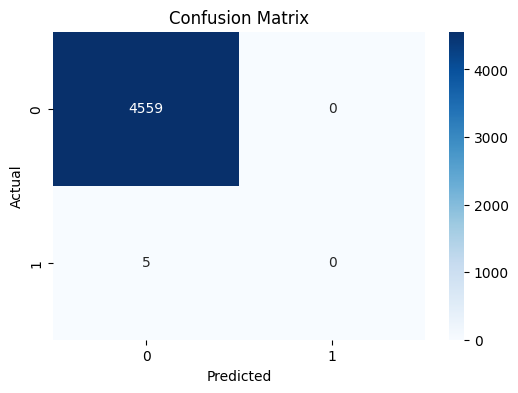

In [38]:
y_pred = model.predict(X_test)
print('\n--- Classification Report ---')
print(classification_report(y_test, y_pred))
print('\n--- Confusion Matrix ---')
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [40]:
# Cell 15 (Unchanged)
joblib.dump(model, '/content/drive/MyDrive/Colab Notebooks/heart_disease_model.pkl')
print('Model saved as heart_disease_model.pkl')

Model saved as heart_disease_model.pkl
